This notebook contains the project for Complex system simulation, Complex financial networks

In [92]:
# imports
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import sys
import os
import time
import datetime
import pickle
import argparse
import itertools
from typing import List, Tuple



# Financial contract network

Agent (nodes) want to enter into contracts with other agents (Links) to reduce their risk exposure. We will simulate what happens over time, studying when a total system collapse becomes more likely to occur as a function of the size of perturbation to the system.

1. There are total of $N$ Agents (nodes) and the i'th agent will have an exposure $e_i$ which initialized as a random number between 1 and -1.

2. Agents try to minimize their exposure by forming a link to another agent with opposite expsure, meaning finding another node with the opposite sign of $e_i$, namely $e_j$ such that the sum of their exposures $\Sigma e$ is as close to 0 as possible. A link is formed if $\Sigma e$ is minimal, if $\Sigma e$ is above a threshold, $T_e$, such that $\Sigma e$ > $T_e$ no link will be formed. 

We have to options for the link weights
- Option A: Suns proposal, see she will upload it later.
- Option B: The link weight is equal to the previous exposure of the node, and links are always biirectional but carry different weights. Thus the link weights become: $W$ is a weight function, so that W(L_{ij}) = $e_{i}$ and W(L_{ji}) = $e_{ji}$ 

3. Each timestep the exposure of an agent is a brownian motion. Agents have exposure to the price of stock. We assume all agents have exposure to the same asset for simplicity. 

Agents have total wealth $W$, which is $e$ times the stock price: $e * S = W$. If W < 0, an agent becomes bankrupt and also dies (meaning the node gets removed). This causes all links $L_{ij}$ to be removed and the values of the weights $W_{L_{ij}}$
$ to be added $e_{j}$ which is the exposure of $N_{j}$, which then increases the chances of $e_{j}$ > $T_e$ and $N_{j}$ dying as a result, causing the effect to propagate.

- Hypothesis is that an increased average move away from the mean causes a higher probability of default when the number of links is higher



Limitations: 
- Bank only link at most twice, which is unrealistic as banks have more transactions
- There is only 1 asset

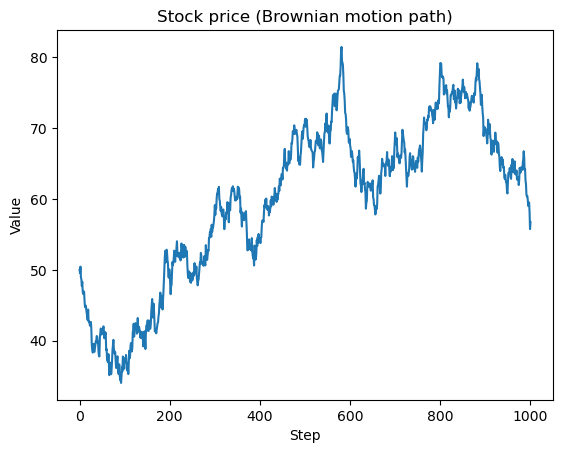

In [93]:
def brownian_motion(num_steps, delta_t, sigma):
    """
    Generate a Brownian motion path.

    Parameters:
    num_steps (int): Number of steps in the Brownian motion.
    delta_t (float): Time increment.
    sigma (float): Standard deviation of the increments (sqrt of variance).

    Returns:
    np.array: A numpy array representing the Brownian motion path.
    """
    # Generate random increments from a normal distribution
    increments = np.random.normal(0, sigma * np.sqrt(delta_t), num_steps)

    # The start point is typically zero
    start_point = 0

    # Compute the Brownian motion path
    return np.cumsum(np.insert(increments, 0, start_point)) +50

# Example usage
num_steps = 1000
delta_t = 0.01
sigma = 10

brownian_path = brownian_motion(num_steps, delta_t, sigma)

# Optionally, you can plot the path
import matplotlib.pyplot as plt

plt.plot(brownian_path)
plt.xlabel('Step')
plt.ylabel('Value')
plt.title('Stock price (Brownian motion path)')
plt.show()


In [94]:
def generate_exposures(N):
    """
    Generate a random set of exposures for N agents.

    Parameters:
    N (int): Number of agents.

    Returns:
    np.array: A numpy array representing the exposures of the agents.
    """
    return np.random.uniform(-1, 1, N)

In [95]:
def create_directional_graph(N_Nodes, edges=None):
    """
    Creates a directed graph using NetworkX.

    This function initializes a directed graph with a specified number of nodes.
    Nodes are numbered from 0 to N_Nodes-1. Optionally, edges can be added to the graph.
    Each edge should be defined as a tuple (u, v) where u and v are the nodes that the edge connects.

    Parameters:
    N_Nodes (int): The number of nodes in the graph.
    edges (list of tuples, optional): A list of edges to add to the graph. Each edge is a tuple (u, v).

    Returns:
    nx.DiGraph: A NetworkX directed graph with N_Nodes and optionally the specified edges.
    """
    
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes
    G.add_nodes_from(range(N_Nodes))

    # Add edges if provided
    if edges is not None:
        for edge in edges:
            G.add_edges_from(edges)

    return G


Agents are willing to link if their summed exposure is small, because then it brings their new exposure closer to 0. The new exposure $E_{i_{t+1}}$ is a random draw between -1 and 1.

If a node cannot find any other node to link with (Due to threshold or or because there are simply no nodes to link with) 

then becomes $E_{i_{t}}$ + the column and row sums of the adjacency matrix. 

In [96]:
def form_links_and_update_exposures(G: nx.Graph, exposures: List[float], linking_threshold: float) -> Tuple[nx.Graph, List[float]]:
    """
    Forms links between nodes in a graph based on exposure values and a linking threshold, 
    and updates the exposures of these nodes.

    Parameters:
    G (nx.Graph): The graph to which the nodes belong.
    exposures (List[float]): A list of exposure values for each node.
    linking_threshold (float): The threshold below which the absolute sum of exposures will trigger a link.

    Returns:
    Tuple[nx.Graph, List[float]]: A tuple containing the updated graph and a list of updated exposures.
    """
    updated_exposures = exposures.copy()

    for i in range(len(exposures)):
        closest_sum = np.inf
        closest_node = None

        for j in range(len(exposures)):
            if i != j:
                sum_of_exposures = exposures[i] + exposures[j]

                if (np.abs(sum_of_exposures) < np.abs(closest_sum)) and (np.abs(sum_of_exposures) < linking_threshold):
                    closest_sum = sum_of_exposures
                    closest_node = j

        if closest_node is not None:
            G.add_edge(i, closest_node, weight=exposures[i])
            updated_exposures[i] += exposures[closest_node]
            G.add_edge(closest_node, i, weight=exposures[closest_node])
            updated_exposures[closest_node] += exposures[i]

    return G, updated_exposures

# Testing the function

In [97]:
# parameters
N = 4 # Number of agents (nodes)
time_steps = 5  # Number of time steps to simulate

In [98]:
# Test the functions    
Graph_updated = create_directional_graph(N)
initial_exposures = generate_exposures(N)
for t in range(time_steps):
    print('timestep', t)
    Graph_updated = form_links_and_update_exposures(G=Graph_updated, exposures=initial_exposures, linking_threshold=0.5)[0]
    print(len(Graph_updated.edges))
    exposures_updated = form_links_and_update_exposures(G=Graph_updated, exposures=initial_exposures, linking_threshold=0.5)[1]
    print(exposures_updated)

timestep 0
4
[-0.05655403  0.92948335 -1.51275662  0.40134457]
timestep 1
4
[-0.05655403  0.92948335 -1.51275662  0.40134457]
timestep 2
4
[-0.05655403  0.92948335 -1.51275662  0.40134457]
timestep 3
4
[-0.05655403  0.92948335 -1.51275662  0.40134457]
timestep 4
4
[-0.05655403  0.92948335 -1.51275662  0.40134457]


In [99]:
# Testing to see if adjecency matrix is updated and shows the expected heterogeneity in link weights
print('initial_exposures:\n', initial_exposures)
print('\n')
Graph_data = form_links_and_update_exposures(G=Graph_updated, exposures=initial_exposures, linking_threshold=2)
Graph_updated = Graph_data[0]
exposures_updated = Graph_data[1]
print('adjacency matrix: \n', nx.adjacency_matrix(Graph_updated).todense())

# we expect to find the intial exposures to be reflected in the weights of the adjaceny matrix

initial_exposures:
 [-0.05655403 -0.9570506   0.94326697 -0.5419224 ]


adjacency matrix: 
 [[ 0.          0.          0.         -0.05655403]
 [ 0.          0.         -0.9570506   0.        ]
 [ 0.          0.94326697  0.          0.94326697]
 [-0.5419224   0.         -0.5419224   0.        ]]


Number of links at threshold 0.0: 0
Number of links at threshold 0.1: 2
Number of links at threshold 0.2: 2
Number of links at threshold 0.3: 2
Number of links at threshold 0.4: 2
Number of links at threshold 0.5: 4
Number of links at threshold 0.6: 6
Number of links at threshold 0.7: 6
Number of links at threshold 0.8: 6
Number of links at threshold 0.9: 6


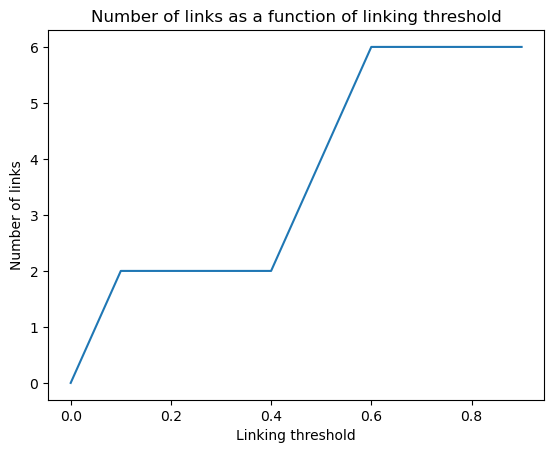

In [100]:
# This cell is purely for testing expected behavior, we expect the number of links to go up as the linking threshold decreases
Graph = create_directional_graph(N_Nodes = 10)
Links_test = []
Link_test_thresholds = []

for i in range(10):
    Graph_updates = form_links_and_update_exposures(G=Graph, exposures=initial_exposures, linking_threshold=i/10)[0]
    print(f'Number of links at threshold {i/10}: {len(Graph_updates.edges)}')
    Links_test.append(len(Graph_updates.edges))
    Link_test_thresholds.append(i/10)
plt.ylabel('Number of links')
plt.xlabel('Linking threshold')
plt.title('Number of links as a function of linking threshold')
plt.plot(Link_test_thresholds, Links_test)
plt.show()


In [101]:
def check_threshold_and_propagate(G, exposures):
    for i in range(len(exposures)):
        if abs(exposures[i]) > T_e:
            # Agent exceeds threshold, remove from graph and adjust linked agents' exposures
            for neighbor in list(G.neighbors(i)):
                exposures[neighbor] += G[i][neighbor]['weight']
            G.remove_node(i)
    return G, exposures


In [102]:
# def check_threshold_and_propagate(G, exposures):
#     for i in range(len(exposures)):
#         if abs(exposures[i]) > T_e:
#             # Agent exceeds threshold, remove from graph and adjust linked agents' exposures
#             for neighbor in list(G.neighbors(i)):
#                 exposures[neighbor] += G[i][neighbor]['weight']
#             G.remove_node(i)
#     return G, exposures
